# Aggregating ATP Match Data into Individual Player Statistics
---
The goal of this notebook is to aggregate data from a database of Association of Tennis Professionals (ATP) matches into individual player statistics, with filters enabeling us to specify a minumim number of matches played, the year or range of years to aggregate over, as well as features to select which tournaments are included in the data e.g. in some instances you may want to omit team competitions like the Davis Cup and Laver Cup. The final aggregated data should be prepared such that it can then be used to perform exploratory data analysis and train and test machine learning models to predict outcomes for players like their year end ranking or match win percentage. All the data being used for this project is pulled from [Jeff Sackmann's Git Repository](https://github.com/JeffSackmann/tennis_atp) of ATP matches, results and statistics.

---
<br>

In [2]:
import pandas as pd
import glob
import copy
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## What does the data we will be working with look like?
---

Before getting into the aggregation, we need to understand the data we are working with and identify which columns we wish to aggregate and which columns might need adjustment

In [3]:
example = pd.read_csv('CSVs/atp_2017.csv')
example.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2017-M020,Brisbane,Hard,32,A,20170102,271,104678,NaN,NaN,Viktor Troicki,R,193.0,SRB,30.8,106415,NaN,Q,Yoshihito Nishioka,L,170.0,JPN,21.2,6-4 7-5,3,R32,91.0,11.0,5.0,64.0,45.0,35.0,6.0,11.0,1.0,3.0,0.0,1.0,82.0,53.0,33.0,13.0,11.0,6.0,10.0,29.0,1385.0,100.0,604.0
1,2017-M020,Brisbane,Hard,32,A,20170102,272,106378,NaN,NaN,Kyle Edmund,R,188.0,GBR,21.9,124014,NaN,Q,Ernesto Escobedo,R,185.0,USA,20.4,7-6(4) 7-6(6),3,R32,130.0,11.0,2.0,83.0,48.0,37.0,19.0,12.0,2.0,3.0,11.0,3.0,113.0,67.0,39.0,27.0,12.0,9.0,10.0,45.0,1001.0,141.0,443.0
2,2017-M020,Brisbane,Hard,32,A,20170102,273,106298,6.0,NaN,Lucas Pouille,R,185.0,FRA,22.8,104468,NaN,NaN,Gilles Simon,R,183.0,FRA,32.0,7-6(6) 7-6(4),3,R32,125.0,7.0,2.0,102.0,52.0,37.0,24.0,12.0,8.0,12.0,1.0,4.0,76.0,42.0,29.0,16.0,12.0,0.0,4.0,15.0,2156.0,25.0,1585.0
3,2017-M020,Brisbane,Hard,32,A,20170102,275,111577,NaN,Q,Jared Donaldson,R,188.0,USA,20.2,104180,NaN,NaN,Gilles Muller,L,193.0,LUX,33.6,6-4 6-4,3,R32,75.0,12.0,2.0,55.0,33.0,27.0,13.0,10.0,0.0,1.0,10.0,2.0,58.0,37.0,27.0,7.0,10.0,2.0,5.0,105.0,570.0,34.0,1255.0
4,2017-M020,Brisbane,Hard,32,A,20170102,276,111442,NaN,WC,Jordan Thompson,R,183.0,AUS,22.7,111200,NaN,WC,Elias Ymer,R,183.0,SWE,20.7,6-3 6-2,3,R32,90.0,1.0,0.0,46.0,28.0,26.0,6.0,8.0,1.0,2.0,1.0,6.0,74.0,43.0,23.0,13.0,9.0,10.0,15.0,79.0,689.0,160.0,372.0


## Adding More Distinct Tournament Levels
---

In [4]:
example.tourney_level.value_counts()

A    1552
M     567
G     508
D     253
F      31
Name: tourney_level, dtype: int64

The first thing I want to address is the 'tourney_level' column. In it's current state, there are 5 distinct catagories. 'G' for Grand Slams, 'F' for the tour finals, 'M' for masters series events, 'D' for Davis Cup and 'A' for everything else (Olympics, Laver Cup, Next Gen Finals, ATP Cup, ATP 250s and ATP 500s). One of the things I want to do with the data is to count the number of finals and titles a player has at each level of the tour, so for this reason I want to assign the tournament level of 500 events a new classification, 'S'. I also want to be able to count the Olympic medals a player has, so for this reason I will assign 'O' to Olympic level events.

To assign the new categoreies, the funciton convert_tourneys uses a dictionary of tournaments, with the keys being the tournament name and the values being the range of years the tournament was an ATP 500 (or equivelant ATP Gold/ ATP Championshop Sieries prior to 2009).

In [5]:
def convert_tourneys(data):
    
    atp_500_dict = {'Rotterdam': range(1999, 2024), 'Rio de Janeiro': range(2014, 2024), 'Acapulco': range(2001, 2024), 'Mexico City': [2000], 'Barcelona': range(1990, 2024),
                    "Queen's Club": range(2015, 2024), 'Milan': range(1993, 1998), 'London': range(1998, 2001), 'Dubai': range(2001, 2024), 'Halle': range(2015, 2024),
                    'Hamburg': range(2009, 2024), 'Washington': list(range(1990, 2003)) + list(range(2009, 2024)), 'Beijing': range(2009, 2024), 'Tokyo Indoor': range(1990, 1996), 'Tokyo': range(2000, 2024),
                    'Astana': [2022], 'Vienna': list(range(1996, 2009))  + list(range(2015, 2024)), 'Basel': range(2009, 2023), 'St. Petersburg': [2020], 'Valencia': range(2009, 2015),
                    'Memphis': range(1991, 2014), 'Indianapolis': range(1990, 2003), 'Kitzbuhel' : range(1999, 2009), 'Stuttgart Outdoor': range(1990, 2001), 'New Haven': range(1990, 1999),
                    'Stuttgart':[2001] + list(range(2003, 2009)), 'Singapore': range(1997, 2000), 'Philadelphia': range(1990, 1999), 'Brussels': range(1990, 1993), 'Toronto Indoor': [1990],
                    'Sydney Indoor': range(1990, 1995),}
    
    olympics_list = ['Barcelona Olympics', 'Atlanta Olympics', 'Beijing Olympics', 'Sydney Olympics', 'London Olympics', 'Rio Olympics', 'Tokyo Olympics', 'Paris Olympics', 
                     'Athens Olympics', 'Los Angeles Olympics', 'Brisbane Olympics',]
    
    for index, row in data.iterrows():
        if (row.tourney_name in atp_500_dict.keys()) and (int(row.tourney_id[0:4]) in atp_500_dict[row.tourney_name]): #first 4 charachters of tourney id is the year the tournament was played
            data.loc[index, 'tourney_level'] = 'S'
        elif (row.tourney_name in olympics_list):
            data.loc[index, 'tourney_level'] = 'O'
    
    return data.copy()

## Adding Lables For Matches That Have Stats and Duration
---

Another thing that became immediately obvious when looking at the data was that many matches, especially older matches pre 2000 don't have any stats or duration values (in minutes). For some of my aggregated stats, normalising over the number of matches played e.g. aces per match, will be importnat, therefore tracking the number of matches with stats and matches with minutes will be vital.

The set_labels function adds two new columns to the data set, a has_minutes column which indicates the match has a minutes value (1 if True, 0 if False) and a has_stats column which indicates if the match had stat tracking.

In [6]:
def set_labels(data):
    data = data.copy()
    data['has_stats'] = data.w_ace.apply(lambda x: 0 if pd.isnull(x) else 1) # if aces are tracked, then so are all other serving and return stats
    data['has_minutes'] = data.minutes.apply(lambda x: 0 if pd.isnull(x) else 1)
    return data

## Counting Number of Sets Played
---
The data has a column, best_of, which indicates whether the match is a best of 3 sets or best of 5 sets. Again, there are a couple of statistics I may want to use that are normalized by number of sets played e.g. double faults per set, therefore it would be useful to write a funcuion that counts the number of sets played. As of right now, a best of 5 set match could be 3, 4, 5 sets or in the case of an early retirement, 1 or 2 sets. The count_sets function calculates this by counting the number of spaces in the 'score' column. In the case of retirements, there is an extra space between the score and 'RET', so the function accounts for this e.g "7-6(4) 6-4" has 1 space - 2 sets played, "6-2 RET" has 1 space but contains 'RET' so sets played is still 1.

In [7]:
def count_sets(score):
    if 'RET' in score:
        return score.count(" ")
    return score.count(" ") + 1

## Retrieving CSVs and Converting to DataFrames Before Aggregation
---
The goal of the get_all_matches function is to produce a dictionary containing DataFrames of ATP matches for each year corresponding to the CSVs in the provided path. For example, if path contained the CSVs for the 2020 and 2021 seasons, get_all_matches would return a dictionary with 2020 and 2021 as the keys and the corresponding DataFrames, with the above functions applied to them, as their values. At this point I thought it would be appropriate to include optional filters which could be applied to each CSV - these filters include include_slams (include Grand Slam matches), include_daviscup (include Davis Cup), bo5_only (only include best-of-5 matches) and bo3_only (only include best-of-3 matches) allowing us to refine our ouput.

More importantly I introduced the by_year parameter. By default, by_year keeps each season's matches seperately, meaning that after aggregation a player will have a row for each season e.g. if the CSVs contain data from 2005 to 2008, Roger Federer would have a row for 2005, 2006, 2007 and 2008. If by_year is set to False, all the matches are concatenated and after aggregation each player would have a single row with stats aggregated over the span of years the CSVs cover e.g. Roger Fededer would have a single row of aggregated stats over the period 2005-2008.

In [8]:
def get_all_matches(path, include_slams=True, include_daviscup=True, by_year=True, bo5_only=False, bo3_only=False):
    
    match_dict_by_year = {}
    all_matches = pd.DataFrame()
    
    for csv in glob.glob(path):   
        if bo5_only:
            df = pd.read_csv(csv).query('best_of == 5')
        elif bo3_only:
            df = pd.read_csv(csv).query('best_of == 3')
        else:
            df = pd.read_csv(csv)
        
        if not include_slams:
            df = df.query('tourney_level != "G"')
        if not include_daviscup:
            df =  df.query('tourney_level != "D"')
        
        # Apply Functions
        df = convert_tourneys(df).reset_index()
        df = set_labels(df).reset_index()
        df['sets'] = df['score'].apply(count_sets)
        df['year'] = df['tourney_id'].apply(lambda x: int(x[0:4])) # first 4 characters of tourney_id is always the year that the tournament was played
        
        if by_year:
            match_dict_by_year[df.loc[0, 'year']] = df
        else:
            all_matches = pd.concat([all_matches, df])
    
    if by_year:
        return match_dict_by_year

    match_dict_all = {}
    min_year = all_matches.year.min()
    max_year = all_matches.year.max()
    all_matches.year = f'{min_year}-{max_year}' # assigns the range of years the CSVs cover to the year column
    match_dict_all[f'{min_year} - {max_year}'] = all_matches

    return match_dict_all

## Aggregating Player Data
---
The goal of matches_to_player is to aggregate player statistics from raw match data. It first finds all of the unique players in the data set, then loops over each player to find all of their matches as the winning player and as the losing player. To help reduce the size of the dataset, I have only included players who have played at least one ATP tour level match i.e. Grand Slams, Masters, 500s and 250s. It does not include players who have only played in Davis Cup or team events. The players included can be further refined by the min_match_wins (minimum match wins) and min_matches_played (minimum matches played) parameters, but by default they are set to 0.

In [9]:
def matches_to_player(data, min_match_wins=0, min_match_played=0):

    player_template = {'year': [0], 'id': [0], 'name': [0], 'age': [0], 'hand': [0], 'height': [0], 'ioc': [0], 'high_rank': [0], 'high_pts': [0], 'tourney_plyd': [0], 'avg_tourney_level':[0], 'matches_plyd': [0],
                'match_wins': [0], 'matches_w_stats': [0], 'matches_w_minutes': [0], 'finals':[0], 'titles': [0], 'slam_finals': [0], 'slams': [0], 'atp_finals_finals': [0], 
                'atp_finals': [0], 'masters_finals': [0], 'masters': [0], '500_titles': [0], '500_finals': [0], '250_finals': [0], '250_titles': [0], 'olympic_g': [0],
                'olympic_s': [0], 'olympic_b': [0],'tb_plyd': [0], 'tb_won': [0], 'no1_faced': [0], 'no1_wins': [0], 'top_5_faced': [0], 'top_5_wins': [0], 'top_10_faced': [0],
                'top_10_wins': [0], 'top_20_faced': [0], 'top_20_wins': [0], 'top_50_faced': [0], 'top_50_wins': [0], 'top_100_faced': [0], 'top_100_wins': [0], 'avg_opponent_rank': [0], 'sets_w_mins': [0], 'sets_w_stats':[0]}

    final_df = pd.DataFrame(player_template)

    df = data.copy()

    players = sorted(set(list(data.winner_name) + list(data.loser_name))) # create list of unique players to loop over

    def get_player_info(matches):
            """Gets a player's basic info from a list of their matches"""
            stats['year'] = [matches.year.iloc[0]]
            stats['id'] = [matches.winner_id.iloc[0]]
            stats['name'] = [matches.winner_name.iloc[0]]
            stats['age'] = [matches.winner_age.max()]
            stats['hand'] = [matches.winner_hand.iloc[0]]
            stats['height'] = [matches.winner_ht.iloc[0]]
            stats['ioc'] = [matches.winner_ioc.iloc[0]]

    for player in players:

        stats = copy.deepcopy(player_template)
        
        all_matches_no_team = df[((df.winner_name == player) | (df.loser_name == player)) & (df.tourney_level != 'D')]
        wins = df[df.winner_name == player]
        losses = df[df.loser_name == player]

        if (len(wins) < min_match_wins) or (len(wins) + len(losses) < min_match_played) or (len(all_matches_no_team) == 0): # only selects players with specified number of match wins or have played at least one main tour match
            continue    # continues to next player
        
        stats['matches_w_minutes'] = wins.has_minutes.sum() + losses.has_minutes.sum()
        stats['matches_w_stats'] = wins.has_stats.sum() + losses.has_stats.sum()
        stats['matches_plyd'] = [len(wins) + len(losses) - len(wins.query('score == "W/O"')) - len(losses.query('score == "W/O"'))] # subtracts wins and losses where match was a walk over (doesnt count as match win or loss)
        stats['match_wins'] = [len(wins) - len(wins.query('score == "W/O"'))]
        
        unique_tourneys = pd.Series(all_matches_no_team.tourney_id.unique()).rename('tourney_id')
        stats['tourney_plyd'] = len(unique_tourneys)
        
        # Calculate an average tournament level based number of events played
        tourney_levels = pd.merge(unique_tourneys, all_matches_no_team[['tourney_id', 'tourney_level']],how='left').drop_duplicates()
        points = 0
        points_dict = {'G':2000, 'M':1000,'S':500, 'A':250, 'F':1500, 'O':1500}
        
        for index, row in tourney_levels.iterrows():
            points += points_dict[row.tourney_level]
        
        stats['avg_tourney_level'] = points / stats['tourney_plyd']
        
        if not len(wins) == 0:
            get_player_info(wins)
        else:
            get_player_info(losses) # If a player has no wins, get basic info from losses
    

        if len(wins) > 0 and len(losses) > 0:
            stats['high_rank'] = [min(min(wins.winner_rank), min(losses.loser_rank))]
            stats['high_pts'] = [max(max(wins.winner_rank_points), max(losses.loser_rank_points))]
        elif len(wins) == 0:
            stats['high_rank'] = min(losses.loser_rank)
            stats['high_pts'] = max(losses.loser_rank_points)
        else:
            stats['high_rank'] = min(wins.winner_rank)
            stats['high_pts']  = max(wins.winner_rank_points)
        
        stats['aces'] = [wins.w_ace.sum(skipna=True) + losses.l_ace.sum(skipna=True)]
        stats['df'] = [wins.w_df.sum(skipna=True) + losses.l_df.sum(skipna=True)]
        
        stats['minutes'] = [wins.minutes.sum(skipna=True) + losses.minutes.sum(skipna=True)]

        stats['sv_games_plyd'] = [wins.w_SvGms.sum(skipna=True) + losses.l_SvGms.sum(skipna=True)]
        stats['sv_pts_plyd'] = [wins.w_svpt.sum(skipna=True) + losses.l_svpt.sum(skipna=True)]
        stats['1st_in'] = [wins.w_1stIn.sum(skipna=True) + losses.l_1stIn.sum(skipna=True)]
        stats['1st_won'] = [wins.w_1stWon.sum(skipna=True) + losses.l_1stWon.sum(skipna=True)]
        stats['2nd_won'] = [wins.w_2ndWon.sum(skipna=True) + losses.l_2ndWon.sum(skipna=True)]

        stats['return_games_plyd'] = [wins.l_SvGms.sum(skipna=True) + losses.w_SvGms.sum(skipna=True)]
        stats['return_pts_plyd'] = [wins.l_svpt.sum(skipna=True) + losses.w_svpt.sum(skipna=True)]
        stats['1st_return_plyd'] = [wins.l_1stIn.sum(skipna=True) + losses.w_1stIn.sum(skipna=True)]
        stats['1st_return_won'] = [(wins.l_1stIn.sum(skipna=True) - wins.l_1stWon.sum(skipna=True)) + (losses.w_1stIn.sum(skipna=True) - losses.w_1stWon.sum(skipna=True))]
        stats['2nd_return_won'] = [(wins.l_svpt.sum(skipna=True) - wins.l_1stIn.sum(skipna=True) - wins.l_2ndWon.sum(skipna=True)) \
                                        + (losses.w_svpt.sum(skipna=True) - losses.w_1stIn.sum(skipna=True) - losses.w_2ndWon.sum(skipna=True))]
        
        stats['bp_faced'] = [wins.w_bpFaced.sum(skipna=True) + losses.l_bpFaced.sum(skipna=True)]
        stats['bp_saved'] = [wins.w_bpSaved.sum(skipna=True) + losses.l_bpSaved.sum(skipna=True)]
        stats['bp_earned'] = [wins.l_bpFaced.sum(skipna=True) + losses.w_bpFaced.sum(skipna=True)]
        stats['bp_won'] = [(wins.l_bpFaced.sum(skipna=True) - wins.l_bpSaved.sum(skipna=True)) + (losses.w_bpFaced.sum(skipna=True) - losses.w_bpSaved.sum(skipna=True))]

        stats['avg_opponent_rank'] = [(wins.loser_rank.sum(skipna=True) + losses.winner_rank.sum(skipna=True)) / (len(wins) + len(losses))]
        stats['avg_opponent_pts'] = [(wins.loser_rank_points.sum(skipna=True) + losses.winner_rank_points.sum(skipna=True)) / (len(wins) + len(losses))]
        
        for index, row in wins.iterrows():

            if row.has_minutes == 1:
                stats['sets_w_mins'][0] += row.sets
            if row.has_stats == 1:
                stats['sets_w_stats'][0] += row.sets

            if row.loser_rank <= 100.0 and row.score != 'W/O':
                stats['top_100_faced'][0] += 1
                stats['top_100_wins'][0] += 1
            if row.loser_rank <= 50.0 and row.score != 'W/O':
                stats['top_50_faced'][0] += 1
                stats['top_50_wins'][0] += 1
            if row.loser_rank <= 20.0 and row.score != 'W/O':
                stats['top_20_faced'][0] += 1
                stats['top_20_wins'][0] += 1    
            if row.loser_rank <= 10.0 and row.score != 'W/O':
                stats['top_10_faced'][0] += 1
                stats['top_10_wins'][0] += 1
            if row.loser_rank <= 5.0 and row.score != 'W/O':
                stats['top_5_faced'][0] += 1
                stats['top_5_wins'][0] += 1
            if row.loser_rank <= 1.0 and row.score != 'W/O':
                stats['no1_faced'][0] += 1
                stats['no1_wins'][0] += 1

            # Winning team competitions or the Next Gen Finals does not count towards a players title count
            if row['round'] == 'F' and row.tourney_level != 'D' and row.tourney_name not in ['Atp Cup', 'NextGen Finals', 'United Cup', 'Laver Cup']:  
                stats['finals'][0] += 1
                stats['titles'][0] += 1
                if row.tourney_level == 'G':
                    stats['slam_finals'][0] += 1
                    stats['slams'][0] += 1
                elif row.tourney_level == 'M':
                    stats['masters_finals'][0] += 1
                    stats['masters'][0] += 1
                elif row.tourney_level == 'F':
                    stats['atp_finals_finals'][0] += 1
                    stats['atp_finals'][0] += 1
                elif row.tourney_level == 'S':
                    stats['500_finals'][0] += 1
                    stats['500_titles'][0] += 1
                elif row.tourney_level == 'O':
                    stats['olympic_g'][0] += 1
                else:
                    stats['250_finals'][0] += 1
                    stats['250_titles'][0] += 1
            
            if row['round'] == 'BR':
                stats['olympic_b'][0] += 1
            
            if '6-7' in row.score:
                score_str = str(row.score)
                tb_l = score_str.count('6-7')
                stats['tb_plyd'][0] += tb_l
            if '7-6' in row.score:
                score_str = str(row.score)
                tb_w = score_str.count('7-6')
                stats['tb_won'][0] += tb_w
                stats['tb_plyd'][0] += tb_w

        for index, row in losses.iterrows():
            
            if row.has_minutes == 1:
                stats['sets_w_mins'][0] += row.sets
            if row.has_stats == 1:
                stats['sets_w_stats'][0] += row.sets
        
            if row.winner_rank <= 100.0 and row.score != 'W/O':
                stats['top_100_faced'][0] += 1
            if row.winner_rank <= 50.0 and row.score != 'W/O':
                stats['top_50_faced'][0] += 1
            if row.winner_rank <= 20.0 and row.score != 'W/O':
                stats['top_20_faced'][0] += 1   
            if row.winner_rank <= 10.0 and row.score != 'W/O':
                stats['top_10_faced'][0] += 1
            if row.winner_rank <= 5.0 and row.score != 'W/O':
                stats['top_5_faced'][0] += 1
            if row.winner_rank <= 1.0 and row.score != 'W/O':
                stats['no1_faced'][0] += 1
            
            if row['round'] == 'F' and row.tourney_level != 'D' and row.tourney_name not in ['Atp Cup', 'NextGen Finals' ,'United Cup', 'Laver Cup']:
                stats['finals'][0] += 1
                if row.tourney_level == 'G':
                    stats['slam_finals'][0] += 1
                elif row.tourney_level == 'M':
                    stats['masters_finals'][0] += 1
                elif row.tourney_level == 'F':
                    stats['atp_finals_finals'][0] += 1
                elif row.tourney_level == 'S':
                    stats['500_finals'][0] += 1
                elif row.tourney_level == 'O':
                    stats['olympic_s'][0] += 1
                else:
                    stats['250_finals'][0] += 1

            if '6-7' in row.score:
                score_str = str(row.score)
                tb_w = score_str.count('6-7')
                stats['tb_won'][0] += tb_w
                stats['tb_plyd'][0] += tb_w
            
            if '7-6' in row.score:
                score_str = str(row.score)
                tb_l = score_str.count('7-6')
                stats['tb_plyd'][0] += tb_l
                
        temp_df = pd.DataFrame(stats)
        temp_df.id = temp_df.id.astype('int64')
        final_df = pd.concat([final_df, temp_df], ignore_index=True)
    
    return final_df.loc[1:,:]

## Cleaning Up and Normalising Player Stats
---
After matches_to_player, we are left with a huge DataFrame with lots of stats that are not useful unless they are somehow normalised. For example, in its current state, the aces column is just the number of aces a player has hit during that year. It would be much more useful to know how many aces per game/ set they hit. Likewise we have stats like '1st_won' which just tells us how many 1st serve points a player has won - again, it would be much more useful to know the rate at which they win 1st serve points. The normalise_player_stats function aims to clean up the DataFrame(s) columns into these 'useful' statistics that we are used to seeing when watching a match on TV. The reduce_columns parameter lets us get rid of the now unwanted columns that were used in calculations.

In [10]:
def normalise_player_stats(data, reduce_columns=True):
    
    df = data.copy()
    
    df['match_win_pct'] = df.match_wins / df.matches_plyd
    df['final_win_pct'] = df.titles / df.finals
    df['tourney_win_pct'] = df.titles / df.tourney_plyd

    df['minutes_per_match'] = df.minutes / df.matches_w_minutes
    df['minutes_per_set'] = df.minutes / df.sets_w_mins

    df['aces_per_game'] = df.aces / df.sv_games_plyd
    df['df_per_game'] = df.df / df.sv_games_plyd

    df['sv_game_win_pct'] = 1 - (df.bp_faced - df.bp_saved) / df.sv_games_plyd
    df['return_game_win_pct'] = df.bp_won / df.return_games_plyd

    df['1st_pct'] = df['1st_in'] / df.sv_pts_plyd

    df['1st_win_pct'] = df['1st_won'] / df['1st_in']
    df['2nd_win_pct'] = df['2nd_won'] / (df.sv_pts_plyd - df['1st_in'])

    df['1st_return_win_pct'] = df['1st_return_won'] / df['1st_return_plyd']
    df['2nd_return_win_pct'] = df['2nd_return_won'] / (df['return_pts_plyd'] - df['1st_return_plyd'])

    df['bp_conversion_rate'] = df.bp_won / df.bp_earned
    df['bp_saved_rate'] = df.bp_saved / df.bp_faced
    df['bp_per_game'] = df.bp_earned / df.return_games_plyd
    df['bp_faced_per_game'] = df.bp_faced / df.sv_games_plyd

    df['tb_win_pct'] = df.tb_won / df.tb_plyd

    df['no1_win_pct'] = df.no1_wins / df.no1_faced
    df['top_5_win_pct'] = df.top_5_wins / df.top_5_faced
    df['top_10_win_pct'] = df.top_10_wins / df.top_10_faced
    df['top_20_win_pct'] = df.top_20_wins / df.top_20_faced
    df['top_50_win_pct'] = df.top_50_wins / df.top_50_faced
    df['top_100_win_pct'] = df.top_100_wins / df.top_100_faced
    
    if reduce_columns:
        
        return df[['year', 'name', 'id', 'age', 'ioc', 'height', 'hand', 'high_rank', 'high_pts', 'tourney_plyd', 'tourney_win_pct', 'avg_tourney_level',
       'matches_plyd', 'match_wins', 'match_win_pct', 'finals', 'titles', 'final_win_pct', 'slam_finals', 'slams','atp_finals_finals', 'atp_finals', 'masters_finals', 'masters', 
       '500_finals', '500_titles', '250_finals', '250_titles', 'olympic_g', 'aces_per_game', 'df_per_game',
       'sv_game_win_pct', 'return_game_win_pct', '1st_pct', '1st_win_pct', '2nd_win_pct', '1st_return_win_pct',
       '2nd_return_win_pct', 'bp_per_game', 'bp_faced_per_game', 'bp_conversion_rate', 'bp_saved_rate', 'tb_win_pct','no1_faced', 'no1_win_pct', 'top_5_faced', 'top_5_win_pct', 'top_10_faced',
       'top_10_win_pct', 'top_20_faced', 'top_20_win_pct', 'top_50_faced', 'top_50_win_pct', 'top_100_faced', 'top_100_win_pct', 'matches_w_stats', 'matches_w_minutes',
       'avg_opponent_rank', 'avg_opponent_pts', 'sets_w_stats', 'sets_w_mins', 'minutes_per_match', 'minutes_per_set',]] # structure of our final DataFrame
    
    return df

## Adding Year-End Rankings and Year-End Ranking Categories
---
Before using the data for EDA and machine learning, I wanted to add the columns which I will be using as labels to make my predictions - in this case Year-End-Ranking and Year-End-Ranking Category. I decided to make these categories becuause they are significant milestones in a players career. Top 100 guarantees entry to the Grand Slams, top 32 means you are seeded for Grand Slams and get direct entry into Masters level events, and top 10 becuse it is presigious and gives you either direct entry or an alternate spot in the year end championships (best 8 players of the year + 2 alternates).

The get_year_end_rankings function gets the year end rankings and year end points tally of players for each year in the dataset and then merges it on player_id. The optional add_categories parameter uses the add_ranking_categories function to compute the categoreies a player belongs in for that year.

In [11]:
def add_ranking_categories(rank):
    if rank <= 10:
        return 'top10'
    elif rank <= 32:
        return 'top32'
    elif rank <= 100:
        return 'top100'
    return '>100'

In [12]:
def get_year_end_rankings(data, add_categories=True):

    years = range(1990, 2024)
    rankings = []

    # concatenate all rankings csv's into a single dataframe which will be used for parsing into years
    for csv in glob.glob('CSVs/rankings*'):
        df = pd.read_csv(csv)
        rankings.append(df)

    rankings = pd.concat(rankings)
    yearly_rankings = {}

    for year in years:
        yearly_rankings[year] = rankings[(rankings.ranking_date > year*10000) & (rankings.ranking_date < (year+1)*10000)]  # format of the ranking_date column is 20200101 for Jan 1st 2020 and 20201231 for Dec 31st 2022

    year_end_rankings = {}

    for year, rankings in yearly_rankings.items():
        year_end_rankings[year] = rankings[rankings.ranking_date == np.max(rankings.ranking_date)].sort_values('rank').reset_index(drop=True) # gets tha rankings at the max value of the date column i.e. the last rankings of the year. e.g. 20201231 for 2020 season
        year_end_rankings[year]['year'] = year

    all_year_end_rankings = pd.concat(year_end_rankings.values())
    all_year_end_rankings.drop('ranking_date', axis=1, inplace=True)
    all_year_end_rankings.rename(columns={'player':'id', 'points': 'year_end_points', 'rank': 'year_end_ranking'}, inplace=True) # renames columns in preperation for merge with player dataframe

    new_df = pd.merge(data, all_year_end_rankings)

    if not add_categories:
        return new_df
    
    else:
        new_df['year_end_ranking_cat'] = new_df.year_end_ranking.apply(add_ranking_categories).astype('category')
        return new_df
        


## Putting It All Together
---
Finally, the get_all_player_stats function takes the dictionary of matches produced by get_all_matches, aggregates all the stats using matches_to_player, normalises and reduces the columns using normalise_player_stats, and adds year end rankinggs and categories using the get_year_end_rankings function. I have also given options here to specify the mininum number of match wins, minimum number of matches played, and whether to normalise and reduce the columns via the parameters of the function. The output of this function is a DataFrame containing seasonal player stats if by_year == True in get_all_matches i.e. 1 row per player per seaon or multi-seasonal aggregated stats if by_year == False i.e. 1 row per player over all seasons in data set. include_year_end needs to be False for multi-season aggregation.

In [13]:
def get_all_player_stats(match_dict, min_match_w=0, min_match_p=0, normalise=True, reduce=True, include_year_end=True):
    
    player_by_year = {}
    
    for year, df in match_dict.items():
        year_df = matches_to_player(df, min_match_wins=min_match_w, min_match_played=min_match_p)
        player_by_year[year] = year_df

    df = pd.concat(player_by_year.values())

    if normalise:
        df = normalise_player_stats(df, reduce_columns=reduce)
    
    if include_year_end:
        df = get_year_end_rankings(df)

    return df


## Creating the Final Data Sets and Outputting to CSVs
---
players_by_year will act as the training/testing set for the machine learning models (1990 - 2021), players_2023 and players_2022 will act as a validation set to evaluate the model(s) performance and make predictions for the 2023 season. A minimum number of matches played of 5 has been used to reduce the size of the data.

In [14]:
match_dict_by_year = get_all_matches('CSVs/atp_*')
players_by_year = get_all_player_stats(match_dict_by_year, min_match_p=5)
players_by_year.to_csv('players_by_year.csv')

## A Look at the Final Data Set
---

In [15]:
players_by_year.sort_values('year_end_points', ascending=False).head(5)

,year,name,id,age,ioc,height,hand,high_rank,high_pts,tourney_plyd,tourney_win_pct,avg_tourney_level,matches_plyd,match_wins,match_win_pct,finals,titles,final_win_pct,slam_finals,slams,atp_finals_finals,atp_finals,masters_finals,masters,500_finals,500_titles,250_finals,250_titles,olympic_g,aces_per_game,df_per_game,sv_game_win_pct,return_game_win_pct,1st_pct,1st_win_pct,2nd_win_pct,1st_return_win_pct,2nd_return_win_pct,bp_per_game,bp_faced_per_game,bp_conversion_rate,bp_saved_rate,tb_win_pct,no1_faced,no1_win_pct,top_5_faced,top_5_win_pct,top_10_faced,top_10_win_pct,top_20_faced,top_20_win_pct,top_50_faced,top_50_win_pct,top_100_faced,top_100_win_pct,matches_w_stats,matches_w_minutes,avg_opponent_rank,avg_opponent_pts,sets_w_stats,sets_w_mins,minutes_per_match,minutes_per_set,year_end_ranking,year_end_points,year_end_ranking_cat
127,2015,Novak Djokovic,104925,28.4,SRB,188.0,R,1.0,15785.0,16,0.687500,1171.875000,89,83,0.932584,15,11,0.733333,4,3,1,1,8,6,2,1,0,0,0,0.435305,0.124769,0.894640,0.344371,0.663879,0.744284,0.602304,0.335566,0.570160,0.779565,0.330869,0.441748,0.681564,0.653846,0,NaN,20,0.800000,36,0.861111,46,0.891304,63,0.904762,83,0.927711,87,50,36.202247,2997.247191,229,134,113.300000,42.276119,1,16585.0,top10
3015,2011,Novak Djokovic,104925,24.5,SRB,188.0,R,1.0,14720.0,15,0.666667,1183.333333,77,70,0.909091,11,10,0.909091,3,3,0,0,6,5,1,1,1,1,0,0.381535,0.159066,0.864294,0.388372,0.652666,0.740907,0.556257,0.356692,0.575360,0.804651,0.390434,0.482659,0.652422,0.473684,5,1.0,16,0.812500,26,0.807692,37,0.837838,62,0.887097,72,0.902778,75,75,34.835443,2984.189873,199,199,114.293333,43.075377,1,13630.0,top10
1872,2013,Rafael Nadal,104745,27.4,ESP,185.0,L,1.0,12030.0,17,0.588235,1029.411765,83,76,0.915663,14,10,0.714286,2,2,1,0,6,5,3,2,2,1,0,0.242059,0.131435,0.880613,0.338428,0.694370,0.729987,0.567836,0.348126,0.542174,0.722707,0.389923,0.468278,0.693820,0.720000,5,0.6,17,0.705882,29,0.827586,38,0.868421,57,0.912281,75,0.920000,81,81,39.602410,2961.168675,196,196,108.469136,44.826531,1,13030.0,top10
2042,2012,Novak Djokovic,104925,25.4,SRB,188.0,R,1.0,13630.0,17,0.352941,1235.294118,87,75,0.862069,11,6,0.545455,3,1,1,1,6,3,1,1,0,0,0,0.472693,0.138418,0.871940,0.347358,0.640784,0.749217,0.563386,0.354893,0.559391,0.743640,0.379473,0.467105,0.662531,0.586207,1,0.0,21,0.619048,34,0.705882,40,0.725000,69,0.826087,79,0.848101,86,86,36.459770,3117.080460,227,227,117.174419,44.392070,1,12920.0,top10
2444,2010,Rafael Nadal,104745,24.4,ESP,185.0,L,1.0,12390.0,17,0.411765,1102.941176,81,71,0.876543,9,7,0.777778,3,3,1,0,3,3,1,1,1,0,0,0.309690,0.119880,0.901099,0.293413,0.671164,0.753537,0.595238,0.309055,0.553543,0.672655,0.321678,0.436202,0.692547,0.758621,1,1.0,8,0.625000,16,0.687500,29,0.758621,53,0.830189,71,0.859155,81,81,65.222222,1972.777778,213,213,119.765432,45.544601,1,12450.0,top10


In [16]:
players_by_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 0 to 6391
Data columns (total 66 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  6392 non-null   int64   
 1   name                  6392 non-null   object  
 2   id                    6392 non-null   int64   
 3   age                   6392 non-null   float64 
 4   ioc                   6392 non-null   object  
 5   height                6340 non-null   float64 
 6   hand                  6392 non-null   object  
 7   high_rank             6366 non-null   float64 
 8   high_pts              6022 non-null   float64 
 9   tourney_plyd          6392 non-null   int64   
 10  tourney_win_pct       6392 non-null   float64 
 11  avg_tourney_level     6392 non-null   float64 
 12  matches_plyd          6392 non-null   int64   
 13  match_wins            6392 non-null   int64   
 14  match_win_pct         6392 non-null   float64 
 15  fina

## Creating CSVs to be used as validation sets
---

In [17]:
match_dict_2023 = get_all_matches('CSVs/Validation Sets/atp_2023*')
players_2023 = get_all_player_stats(match_dict_2023, min_match_p=5)
players_2023.to_csv('players_2023.csv')

In [18]:
match_dict_2022 = get_all_matches('CSVs/Validation Sets/atp_2022*')
players_2022 = get_all_player_stats(match_dict_2022, min_match_p=5)
players_2022.to_csv('players_2022.csv')

## ATP Ranking Changes
---
There were major changes to the ranking points structure before the 2009 season, giving more weight to Grand Slams and masters series events. The result of which was overal points totals that were significantly higher than seasons before hand. There were also some minor changes for the 2000 season. Becuase of these changes, for the purpose of a regresson machine learning model it makes sense to have an alternative training set of data that only contains data from 2009 onwards. Likewise there is also a dataset for 2000 onwards in case it might be needed.

In [19]:
match_dict_2009_2021 = get_all_matches('CSVs/2009-2021/atp*')
players_2009_2021 = get_all_player_stats(match_dict_2009_2021, min_match_p=5).to_csv('players_2009_2021.csv')


In [20]:
match_dict_2000_2021 = get_all_matches('CSVs/2000-2021/atp*')
players_2000_2021 = get_all_player_stats(match_dict_2000_2021, min_match_p=5).to_csv('players_2000_2021.csv')


## Aggregating Player Stats Over the Whole Data Set (1990 - 2021)
---

players is a players statistics, aggregated over the entire data set (1990 -)

In [21]:
match_dict = get_all_matches('CSVs/atp_*', by_year=False)
players = get_all_player_stats(match_dict, min_match_p=5, include_year_end=False)
players.to_csv('players.csv')

## Example EDA Using ATP Match Data: Compare World No.1's Win Percentage Whilst They Were No.1 Compared to Career Average (1990-2021)
---
Before moving on to performing EDA on aggregated player statistics, I wanted to answer a question I saw online whilst doing the project: Which number 1 ranked player was the most dominant whilst they held the number 1 ranking? Often once players reached the top they failed to maintain their form, or the pressure that came from haolding the top spot. To do this I will compare a players career average win percentage and their win percentage whilst they were ranked 1.

In [22]:
no_1s = players.query('high_rank == 1').name # Series containing names of players who have held the no. 1 ranking (1990-2021)
all_matches = match_dict['1990 - 2021']

no1_as1 = {}
no1_overall = {}

for player in no_1s:
    wins_as1 = all_matches[(all_matches['winner_name'] == player) & (all_matches['winner_rank'] == 1) & (all_matches['score'] != "W/O")]
    losses_as1 = all_matches[(all_matches['loser_name'] == player) & (all_matches['loser_rank'] == 1) & (all_matches['score'] != "W/O")]
    total_wins_as1 = len(wins_as1)
    total_losses_as1 = len(losses_as1)

    if total_wins_as1 != 0 and total_losses_as1 != 0:
        win_pct_as1 = total_wins_as1 / (total_wins_as1 + total_losses_as1)
    else:
        win_pct_as1 = 0
    
    no1_as1[player] = round(win_pct_as1*100, 2)

    wins_overall  = all_matches[(all_matches['winner_name'] == player) & (all_matches['score'] != "W/O")]
    losses_overall = all_matches[(all_matches['loser_name'] == player) & (all_matches['score'] != "W/O")]
    total_wins_overall = len(wins_overall)
    total_losses_overall = len(losses_overall)
    
    if total_wins_overall != 0 and total_losses_overall != 0:
        win_pct_overall = total_wins_overall / (total_wins_overall + total_losses_overall)
    else:
        win_pct_overall = 0
    
    no1_overall[player] = round(win_pct_overall*100, 2)

df = pd.DataFrame(data={'Player' : no_1s,
                        'Overall' : no1_overall.values(),
                        'AsNo1' : no1_as1.values(),}).reset_index(drop=True).sort_values('AsNo1', ascending=False)

In [29]:
df.reset_index(drop=True)

,Player,Overall,AsNo1
0,Roger Federer,82.00,88.50
1,Ivan Lendl,69.84,88.37
2,Novak Djokovic,83.24,87.47
3,Rafael Nadal,83.06,85.94
4,Pete Sampras,79.18,82.92
5,Stefan Edberg,73.31,82.46
6,Lleyton Hewitt,70.16,80.56
7,Andre Agassi,76.88,79.26
8,Jim Courier,69.30,79.00
9,Juan Carlos Ferrero,64.64,78.57


<Figure size 1200x800 with 0 Axes>

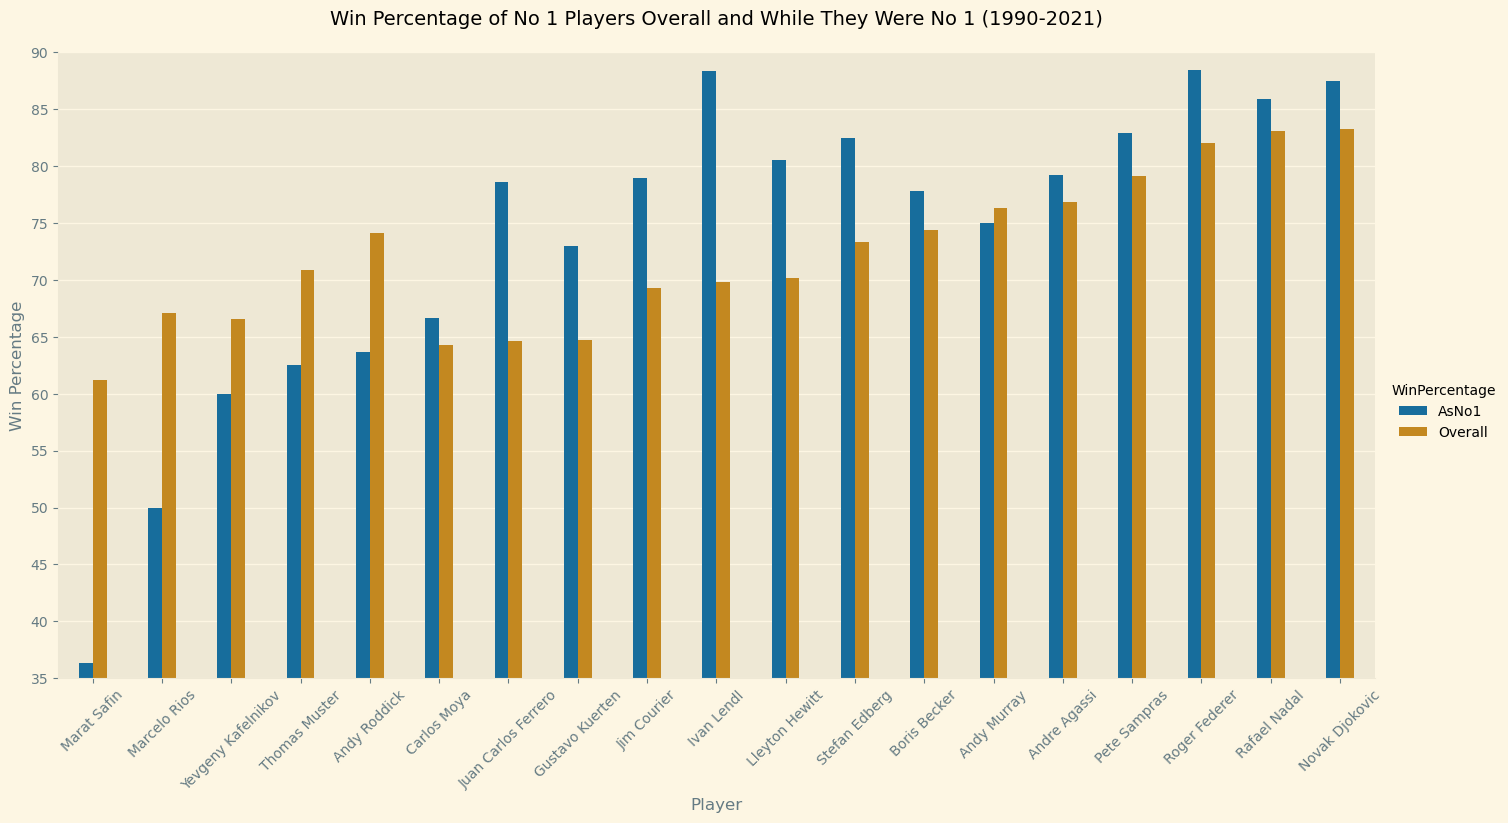

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
sns.color_palette("rocket")

df1 = pd.melt(df, id_vars='Player')
df1 = df1.rename(columns={'variable': 'WinPercentage', 'value':'Win Percentage'})
df1 = df1.sort_values('Win Percentage')

fig1 = plt.figure(figsize=(12, 8))
sns.catplot(x='Player', y='Win Percentage', hue='WinPercentage', data=df1, kind='bar', height=7, aspect=2, palette='colorblind', col_order=df1.Player, width=0.4)
plt.xticks(rotation=45)
plt.yticks(range(30, 95, 5))
plt.ylim(35, 90)
plt.title('Win Percentage of No 1 Players Overall and While They Were No 1 (1990-2021)', pad=20, fontsize=14)
plt.savefig('No1WinPercentage', dpi=300, facecolor=fig1.get_facecolor())
